<a href="https://colab.research.google.com/github/MaartenCVonk/Causal-Modeling/blob/main/Layman's_explanation_ATE_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we recalculate the causal effect of the Layman's presentation to show that our numerical solution correspond with the computational solution of Dowhy. We consider various causal graph structures and let Dowhy calculate the causal effects.

In [1]:
!pip install dowhy &> /dev/nul
!pip install git+git://github.com/mkrphys/ipython-tikzmagic.git &> /dev/nul
!pip install econml &> /dev/nul

In [2]:
import dowhy
import seaborn as sns
import numpy as np
import pandas as pd
import dowhy.api
import graphviz
import matplotlib.pyplot as plt
%load_ext tikzmagic

We have observations of people sleeping with shoes on $S$, people with cramp in their muscles in the morning $X$ and people waking up with headache $H$ corresponding to the following table:



Table  | Shoes | No shoes
-------------------|--------------------|--------------
Headache and Cramp       | 70     |260
Headache and no Cramp       | 10      |40
No Headache and Cramp       | 5      |50
No Headache and no Cramp       | 15      |1150

In [3]:
# We replicate this table by distribution, so not exactly.
N = 160000

s = np.random.binomial(size=N, p=(1/16), n=1)
x = np.random.binomial(n=1, p=(310+815*s)/1500)   # 3/4 310/1500
h = np.random.binomial(1., p=40/1190+2970*x/3689+218*s/595-15038*s*x/55335)  # 70/75 als s=1 en x=1, 2/5 s=1 en x=0, 260/310 als s=0 en x=1, 40/1190 als s=0 en x=0
#h = np.random.binomial(1., p=1./(1. + np.exp(-5. * s))) 

df = pd.DataFrame({'S': s, 'X': x, 'H': h})
df.groupby(['H', 'X','S']).size().unstack()

S         0     1
H X              
0 0  114616  1515
  1    5051   475
1 0    3985   996
  1   26274  7088

## **Example 1: Naive Setting Effect S->H**

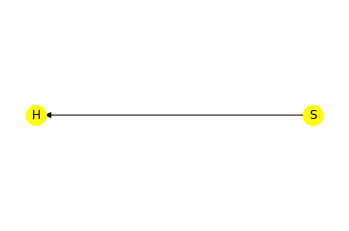

In [4]:
from graphviz import Digraph

causal_graph = """digraph {
H[label="Headache"];
S[label="Shoes"];
S->H;

}"""

model= dowhy.CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment='S',
        outcome='H')

# Let Dowhy plot the model just for verification purposes:
model.view_model(layout="dot")

In [5]:
# Check if the variable can be identified and calculate average causal effect:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
estimate = model.estimate_effect(identified_estimand,
                                 method_name='backdoor.linear_regression',target_units="ate")
print(estimate)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                  
────(Expectation(H))
d[S]                
Estimand assumption 1, Unconfoundedness: If U→{S} and U→H then P(H|S,,U) = P(H|S,)

## Realized estimand
b: H~S
Target units: ate

## Estimate
Mean value: 0.6006355485316517



## **Example 2: S is the common confounder Effect S->H**

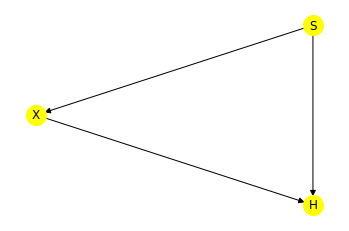

In [6]:
from graphviz import Digraph

causal_graph = """digraph {
X[label="History"];
H[label="Headache"];
S[label="Shoes"];
S -> X;
X -> H;
S -> H;
}"""

model= dowhy.CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment='S',
        outcome='H')

# Let Dowhy plot the model just for verification purposes:
model.view_model(layout="dot")

In [7]:
# Check if the variable can be identified:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                  
────(Expectation(H))
d[S]                
Estimand assumption 1, Unconfoundedness: If U→{S} and U→H then P(H|S,,U) = P(H|S,)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Check if the values indeed correspond to the numerical example:

In [8]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name='backdoor.linear_regression',target_units="ate")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                  
────(Expectation(H))
d[S]                
Estimand assumption 1, Unconfoundedness: If U→{S} and U→H then P(H|S,,U) = P(H|S,)

## Realized estimand
b: H~S
Target units: ate

## Estimate
Mean value: 0.6006355485316517



## **Example 3: X is Treatment Assignment Mechanism of S Effect S->H**

We have observations of people sleeping with shoes on $S$, people with cold feet $X$ and people waking up with headache $H$ corresponding to the following table:

Table  | Shoes | No shoes
-------------------|--------------------|--------------
Headache and Cold Feet       | 70     |260
Headache and no Cold Feet       | 10      |40
No Headache and Cold Feet       | 5      |50
No Headache and no Cold Feet       | 15      |1150

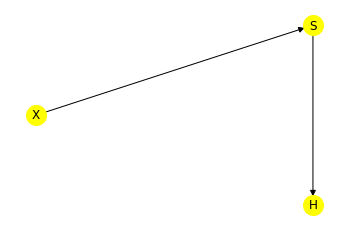

In [9]:
from graphviz import Digraph

causal_graph = """digraph {
X[label="History"];
H[label="Headache"];
S[label="Shoes"];
X -> S;
S -> H;
}"""

model= dowhy.CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment='S',
        outcome='H')

# Let Dowhy plot the model just for verification purposes:
model.view_model(layout="dot")

In [10]:
# Check if the variable can be identified:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                  
────(Expectation(H))
d[S]                
Estimand assumption 1, Unconfoundedness: If U→{S} and U→H then P(H|S,,U) = P(H|S,)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(H, [X])*Derivative([S], [X])**(-1))
Estimand assumption 1, As-if-random: If U→→H then ¬(U →→{X})
Estimand assumption 2, Exclusion: If we remove {X}→{S}, then ¬({X}→H)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [11]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name='backdoor.linear_regression',target_units="ate")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                  
────(Expectation(H))
d[S]                
Estimand assumption 1, Unconfoundedness: If U→{S} and U→H then P(H|S,,U) = P(H|S,)

## Realized estimand
b: H~S
Target units: ate

## Estimate
Mean value: 0.6006355485316517



## **Example 4: Conditional Average Treatment:**

We have observations of people sleeping with shoes on $S$, people with regular migraines $X$ and people waking up with headache $H$ corresponding to the following table:

Table  | Shoes | No shoes
-------------------|--------------------|--------------
Headache and Migraines       | 70     |260
Headache and no Migraines       | 10      |40
No Headache and Migraines       | 5      |50
No Headache and no Migraines      | 15      |1150

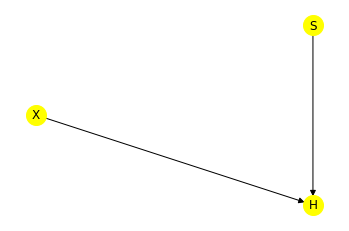

In [12]:
from graphviz import Digraph

causal_graph = """digraph {
X[label="History"];
H[label="Headache"];
S[label="Shoes"];
X -> H;
S -> H;
}"""

model= dowhy.CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment='S',
        outcome='H')

# Let Dowhy plot the model just for verification purposes:
model.view_model(layout="dot")

In [13]:
# Check if the variable can be identified:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                    
────(Expectation(H|X))
d[S]                  
Estimand assumption 1, Unconfoundedness: If U→{S} and U→H then P(H|S,X,U) = P(H|S,X)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [14]:
# First we consider the case P(H|do(S), X=1)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
import econml
estimate = model.estimate_effect(identified_estimand,
                                 method_name='backdoor.linear_regression', control_value=0,treatment_value=1)
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X"]==1,  # condition used for CATE
                                 confidence_intervals=False,                                
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})

print(dml_estimate)



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                    
────(Expectation(H|X))
d[S]                  
Estimand assumption 1, Unconfoundedness: If U→{S} and U→H then P(H|S,X,U) = P(H|S,X)

## Realized estimand
b: H~S+X | X
Target units: Data subset defined by a function

## Estimate
Mean value: 0.0986742340259448
Effect estimates: [0.09867423 0.09867423 0.09867423 ... 0.09867423 0.09867423 0.09867423]



In [15]:
# Then we consider the case P(H|do(S), X=0)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
import econml
estimate = model.estimate_effect(identified_estimand,
                                 method_name='backdoor.linear_regression', control_value=0,treatment_value=1)
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X"]==0,  # condition used for CATE
                                 confidence_intervals=False,                                
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})

print(dml_estimate)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                    
────(Expectation(H|X))
d[S]                  
Estimand assumption 1, Unconfoundedness: If U→{S} and U→H then P(H|S,X,U) = P(H|S,X)

## Realized estimand
b: H~S+X | X
Target units: Data subset defined by a function

## Estimate
Mean value: 0.36181921080706486
Effect estimates: [0.36181921 0.36181921 0.36181921 ... 0.36181921 0.36181921 0.36181921]



## **Example 4: X Common Confounder Effect S->H**

We have observations of people sleeping with shoes on $S$, people drinking $X$ and people waking up with headache $H$ corresponding to the following table:

Table  | Shoes | No shoes
-------------------|--------------------|--------------
Headache and Drinking       | 70     |260
Headache and no Drinking       | 10      |40
No Headache and Drinking       | 5      |50
No Headache and no Drinking       | 15      |1150

In [16]:
df['S']=df['S'].astype(bool)
df['H']=df['H'].astype(bool)
df['X']=df['X'].astype(bool)

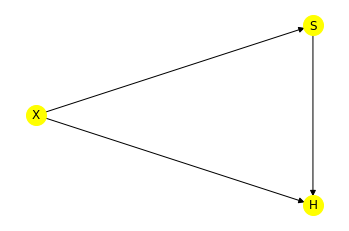

In [17]:
from graphviz import Digraph

causal_graph = """digraph {
X[label="History"];
H[label="Headache"];
S[label="Shoes"];
X -> H;
S->H;
X ->S;
}"""

model= dowhy.CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment='S',
        outcome='H')

# Let Dowhy plot the model just for verification purposes:
model.view_model(layout="dot")

In [18]:
# Check if the variable can be identified:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                    
────(Expectation(H|X))
d[S]                  
Estimand assumption 1, Unconfoundedness: If U→{S} and U→H then P(H|S,X,U) = P(H|S,X)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [19]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name='backdoor.propensity_score_stratification',target_units="ate")
print(estimate)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                    
────(Expectation(H|X))
d[S]                  
Estimand assumption 1, Unconfoundedness: If U→{S} and U→H then P(H|S,X,U) = P(H|S,X)

## Realized estimand
b: H~S+X
Target units: ate

## Estimate
Mean value: 0.2987398878770378



evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
